# Melbourne Datathon
***
## Can Electricity Consumption Patterns Tell Us Anything About The Pandemic?
<br>

**Background**<br>
Covid-19 has affected our lives in various different ways. Electricity consumption is one of the major factors that has also been heavily affected. Considering the very long lockdown in Victoria, Australia, it is interesting to see the various aspects influencing the fluctuations in the demand and pricing of electricity. Due to these unexpected fluctuations, energy providing companies might have faced unprecedented scenarios where their traditional time-series forecasting models might not have performed up to the mark. Here, we will see the different causes that might have created an impact during the Covid-19 lockdown and based on those, we will build a prediction model which learns from the pre Covid-19 data and forecasts the electricity prices for the Covid-19 period, in Victoria.

## Table of Contents

* [1. Data Import](#1)
    * [1.1 Reading the data files](#1.1)
    * [1.2 Filtering the attributes](#1.2)
    * [1.3 Joining the dataframes](#1.3)
* [2. Data Preparation and Exploration](#2)
    * [2.1 Adding new features](#2.1)
    * [2.2 Getting data ready for engineering ](#2.2)
    * [2.3 Exploring the data](#2.3)
* [3. Feature Engineering](#3)
    * [3.1 One-Hot Encoding](#3.1)
    * [3.2 Preparing training and testing data](#3.2)
    * [3.3 Scaling the data](#3.3)
* [4. Multi-layer Perceptron - Artificial Neural Network](#4)
    * [4.1 Training the MLP-ANN model](#4.1)
    * [4.2 Getting the predictions](#4.2)
    * [4.3 Testing the MLP-ANN model](#4.3)
    * [4.4 Plotting the labels and predictions for comparison](#4.4)

### Import the libraries

In [1]:
# Import the required machine learning libraries
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, mean_squared_error

# Import the required processing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Import the required plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Data Import <a class="anchor" id="1"></a>
## 1.1 Reading the data files <a class="anchor" id="1.1"></a>

In [2]:
# Import the electricity price and demand data
df_demand = dd.read_csv('data/Electricity/PriceAndDemand/*')
# Convert the dask dataset to a pandas dataframe
df_demand = df_demand.compute().reset_index()

# Import the maximum temperature data
df_temp_max = pd.read_csv('data/Climate/Temperature/IDCJAC0010_086338_1800_Data.csv')

# Import the minimum temperature data
df_temp_min = pd.read_csv('data/Climate/Temperature/IDCJAC0011_086338_1800_Data.csv')

# Import the solar radiation data
df_solar = pd.read_csv('data/Climate/Solar/IDCJAC0016_086338_1800_Data.csv')

# Import the rainfall data
df_rainfall = pd.read_csv('data/Climate/Rainfall/IDCJAC0009_086338_1800_Data.csv')

# Import the Victorian household, income and population statistical data
df_stats = pd.read_csv('data/MoreFeatures/statistical.csv')
df_income = pd.read_csv('data/MoreFeatures/personal_income.csv')

# Import the Victorian public holiday list data
df_public_holiday = pd.read_csv('data/MoreFeatures/public_holiday.csv')

## 1.2 Filtering the attributes <a class="anchor" id="1.2"></a>

### Filter the price and demand dataframe

In [3]:
# Drop the unnecessary columns from price and demand dataframe
df_demand = df_demand.drop(['index', 'REGION', 'PERIODTYPE'], axis = 1)

In [4]:
# Convert the date-time column to the appropriate data type
df_demand['SETTLEMENTDATE'] = pd.to_datetime(df_demand['SETTLEMENTDATE'])

# Separate the date and time into 2 new columns
df_demand['Date'] = [d.date() for d in df_demand['SETTLEMENTDATE']]
df_demand['Time'] = [d.time() for d in df_demand['SETTLEMENTDATE']]

# Convert the date-time column to the appropriate data type and format
df_demand['Date'] = pd.to_datetime(df_demand['Date'])
df_demand['Date'] = df_demand['Date'].dt.strftime('%Y-%m-%d')
df_demand['Date'] = pd.to_datetime(df_demand['Date'])

In [5]:
# Print out the price and demand dataframe
df_demand

,SETTLEMENTDATE,TOTALDEMAND,RRP,Date,Time
0,2016-01-01 00:30:00,5197.34,35.52,2016-01-01,00:30:00
1,2016-01-01 01:00:00,4934.54,38.29,2016-01-01,01:00:00
2,2016-01-01 01:30:00,4721.32,29.30,2016-01-01,01:30:00
3,2016-01-01 02:00:00,4541.24,31.28,2016-01-01,02:00:00
4,2016-01-01 02:30:00,4344.18,23.87,2016-01-01,02:30:00
...,...,...,...,...,...
84043,2020-10-16 22:00:00,4504.95,41.46,2020-10-16,22:00:00
84044,2020-10-16 22:30:00,4390.47,44.99,2020-10-16,22:30:00
84045,2020-10-16 23:00:00,4297.82,41.46,2020-10-16,23:00:00
84046,2020-10-16 23:30:00,4488.44,44.03,2020-10-16,23:30:00


### Filter the climate dataframes

In [6]:
# Drop the unnecessary columns and rename the value column appropriately
df_temp_max = df_temp_max.drop(['Product code',
                                'Bureau of Meteorology station number',
                                'Days of accumulation of maximum temperature',
                                'Quality'], axis = 1).rename({'Maximum temperature (Degree C)': 'MaxTemp'}, axis = 1)

# Drop the unnecessary columns and rename the value column appropriately
df_temp_min = df_temp_min.drop(['Product code',
                                'Bureau of Meteorology station number',
                                'Days of accumulation of minimum temperature',
                                'Quality'], axis = 1).rename({'Minimum temperature (Degree C)': 'MinTemp'}, axis = 1)

# Drop the unnecessary columns and rename the value column appropriately
df_solar = df_solar.drop(['Product code',
                          'Bureau of Meteorology station number'], axis = 1)\
                            .rename({'Daily global solar exposure (MJ/m*m)': 'SolarExposure'}, axis = 1)
# Fill the null values with an average solar radiation value
df_solar = df_solar.fillna(18)

# Drop the unnecessary columns and rename the value column appropriately
df_rainfall = df_rainfall.drop(['Product code',
                                'Bureau of Meteorology station number',
                                'Period over which rainfall was measured (days)',
                                'Quality'], axis = 1).rename({'Rainfall amount (millimetres)': 'Rainfall'}, axis = 1)
# Fill the null values with 0 rainfall on that day
df_rainfall = df_rainfall.fillna(0)

## 1.3 Joining the dataframes <a class="anchor" id="1.3"></a>

In [7]:
# Join the 4 climate related dataframes imported above
temp = pd.merge(df_temp_max, df_temp_min, how = 'inner', on = ['Year', 'Month', 'Day'])
temp_sol = pd.merge(temp, df_solar, how = 'inner', on = ['Year', 'Month', 'Day'])
df_climate = pd.merge(temp_sol, df_rainfall, how = 'inner', on = ['Year', 'Month', 'Day'])

In [8]:
# Remove all the records before the year 2016
df_climate = df_climate[df_climate.Year > 2015].reset_index().drop('index', axis = 1)

In [9]:
# Create a single date column from the year, month and day columns
date = pd.to_datetime(df_climate[['Year', 'Month', 'Day']])
df_climate['Date'] = date

# Drop the 3 individual year, month and day columns
df_climate = df_climate.drop(['Year', 'Month', 'Day'], axis = 1) 

In [10]:
# Print out the climate dataframe
df_climate

,MaxTemp,MinTemp,SolarExposure,Rainfall,Date
0,24.2,19.8,22.0,0.0,2016-01-01
1,27.6,17.1,25.1,0.0,2016-01-02
2,27.1,17.5,25.7,0.0,2016-01-03
3,26.0,16.3,15.3,0.0,2016-01-04
4,25.7,17.1,25.8,0.0,2016-01-05
...,...,...,...,...,...
1746,25.5,6.3,20.0,0.0,2020-10-12
1747,16.6,10.6,13.6,0.2,2020-10-13
1748,22.7,11.9,21.8,0.0,2020-10-14
1749,24.8,13.8,5.1,0.0,2020-10-15


In [11]:
# Join the price-demand and climate dataframes
merged_temp = pd.merge(df_demand, df_climate, how = 'left', on = ['Date'])

In [12]:
# Separate the 3 individual year, month and day columns to perform further data processing
merged_temp['Day'] = merged_temp['Date'].dt.day
merged_temp['Month'] = merged_temp['Date'].dt.month
merged_temp['Year'] = merged_temp['Date'].dt.year

In [13]:
# Join the above merged data with the statistical dataframes
merged = pd.merge(merged_temp, df_stats, how = 'left', on = ['Year'])
merged = pd.merge(merged, df_income, how = 'left', on = ['Year', 'Month'])

# Further join the merged data with the public holiday dataframe
merged = pd.merge(merged, df_public_holiday, how = 'left', on = ['Year', 'Month', 'Day'])
# Fill the null values with 'No' as no holidays on the remaining days
merged['PublicHoliday'] = merged['PublicHoliday'].fillna('No')

# 2. Data Preparation <a class="anchor" id="2"></a>
## 2.1 Adding new features <a class="anchor" id="2.1"></a>

In [14]:
# Create a separate column for the days of the week
merged['DayOfWeek'] = merged['Date'].dt.day_name()

# Create a separate column for weeks of the year
merged['WeekNumber'] = merged['Date'].dt.isocalendar().week
# Convert the feature to an object so that it is treated as a categorical feauture
merged['WeekNumber'] = merged['WeekNumber'].astype(str)

In [15]:
# Create a new column to identify the weekdays and weekends
def weektime(row):
    if row['DayOfWeek'] == 'Saturday':
        val = 'Weekend'
    elif row['DayOfWeek'] == 'Sunday':
        val = 'Weekend'
    else:
        val = 'Weekday'
    return val
merged['WeekTime'] = merged.apply(weektime, axis=1)


# Create a new column to identify the seasons in Victoria
def season(row):
    if (row['Month'] >= 3) & (row['Month'] <= 5):
        val = 'Autumn'
    elif (row['Month'] >= 6) & (row['Month'] <= 8):
        val = 'Winter'
    elif (row['Month'] >= 9) & (row['Month'] <= 11):
        val = 'Spring'
    else:
        val = 'Summer'
    return val
merged['Season'] = merged.apply(season, axis=1)


# Identify the school holidays for the years 2016 to 2020 in Victoria
def holiday(row):
    if (row['Year'] == 2020) & (row['Month'] == 3) & (row['Day'] >= 28):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 4) & (row['Day'] <= 13):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 6) & (row['Day'] >= 27):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 7) & (row['Day'] <= 12):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 9) & (row['Day'] >= 19):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 10) & (row['Day'] <= 4):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 12) & (row['Day'] >= 19):
        val = 'Yes'
    elif (row['Year'] == 2021) & (row['Month'] == 1) & (row['Day'] <= 26):
        val = 'Yes'
    
    elif (row['Year'] == 2019) & (row['Month'] == 4) & (row['Day'] >= 6) & (row['Day'] <= 22):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 6) & (row['Day'] >= 29):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 7) & (row['Day'] <= 14):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 9) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 10) & (row['Day'] <= 6):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 12) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2020) & (row['Month'] == 1) & (row['Day'] <= 28):
        val = 'Yes'
        
    elif (row['Year'] == 2018) & (row['Month'] == 3) & (row['Day'] >= 30):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 4) & (row['Day'] <= 15):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 6) & (row['Day'] >= 30):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 7) & (row['Day'] <= 15):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 9) & (row['Day'] >= 22):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 10) & (row['Day'] <= 7):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 12) & (row['Day'] >= 22):
        val = 'Yes'
    elif (row['Year'] == 2019) & (row['Month'] == 1) & (row['Day'] <= 29):
        val = 'Yes'
    
    elif (row['Year'] == 2017) & (row['Month'] == 4) & (row['Day'] >= 1):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 4) & (row['Day'] <= 17):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 7) & (row['Day'] >= 1):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 7) & (row['Day'] <= 16):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 9) & (row['Day'] >= 23):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 10) & (row['Day'] <= 8):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 12) & (row['Day'] >= 23):
        val = 'Yes'
    elif (row['Year'] == 2018) & (row['Month'] == 1) & (row['Day'] <= 28):
        val = 'Yes'
        
    elif (row['Year'] == 2016) & (row['Month'] == 3) & (row['Day'] >= 25):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 4) & (row['Day'] <= 10):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 6) & (row['Day'] >= 25):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 7) & (row['Day'] <= 10):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 9) & (row['Day'] >= 17):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 10) & (row['Day'] <= 2):
        val = 'Yes'
    elif (row['Year'] == 2016) & (row['Month'] == 12) & (row['Day'] >= 21):
        val = 'Yes'
    elif (row['Year'] == 2017) & (row['Month'] == 1) & (row['Day'] <= 30):
        val = 'Yes'
        
    else:
        val = 'No'
    
    return val
merged['School'] = merged.apply(holiday, axis=1)

# Categorise the school holiday feature based on school timings
merged['SchoolHoliday'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 9) & (merged.SETTLEMENTDATE.dt.hour <= 15),
                                   'No',
                                   'Yes')

# Categorise the school holiday feature based on public holidays and weekends
merged['SchoolHoliday'] = np.where((merged.School == 'Yes') | (merged.PublicHoliday == 'Yes') | (merged.WeekTime == 'Weekend'),
                                   'Yes',
                                   merged['SchoolHoliday'])

# Categorise the school holiday feature based on Covid-19 period as the schools are shut due to lockdown
merged['SchoolHoliday'] = np.where((merged.SETTLEMENTDATE > '2020-03-23'),
                                   'Yes',
                                   merged['SchoolHoliday'])

# Drop the extra column created in the process
merged = merged.drop(['School'], axis = 1)


# Categorise the industry holiday feature based on public holidays, weekends and Covid-19 period as the offices are shut too
merged['IndustryHoliday'] = np.where((merged.PublicHoliday == 'Yes')\
                                     | (merged.WeekTime == 'Weekend')\
                                     | (merged.SETTLEMENTDATE > '2020-03-23'),
                                     'Yes',
                                     'No')


# Create a new column to identify the period of the day based on the time
merged['DayTime'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 5) & (merged.SETTLEMENTDATE.dt.hour <= 11),
                             'Morning',
                             np.where((merged.SETTLEMENTDATE.dt.hour >= 12) & (merged.SETTLEMENTDATE.dt.hour <= 15),
                                      'Afternoon',
                                      np.where((merged.SETTLEMENTDATE.dt.hour >= 16) & (merged.SETTLEMENTDATE.dt.hour <= 18),
                                               'Evening',
                                               'Night')))


# Create a new column to identify the lighting condition of the day based on the time
merged['LightCondition'] = np.where((merged.SETTLEMENTDATE.dt.hour >= 7) & (merged.SETTLEMENTDATE.dt.hour <= 18),
                                    'Light',
                                    'Dark')


# def area(row):
#     if (row['ServiceProvider'] == 'CITIPOWER'):
#         val = 'Inner Melbourne'
#     elif (row['ServiceProvider'] == 'POWERCOR'):
#         val = 'West Victoria'
#     elif (row['ServiceProvider'] == 'TXU'):
#         val = 'East & Northeast Victoria'
#     elif (row['ServiceProvider'] == 'UNITED'):
#         val = 'Southeast Victoria'
        
#     else:
#         val = 'Northwest Victoria'
        
#     return val

# merged['ProfileArea'] = merged.apply(area, axis=1)

## 2.2 Getting data ready for engineering <a class="anchor" id="2.2"></a>

In [16]:
# Drop the extra date column
df = merged.drop(['Date'], axis = 1)

# Convert the day, month, year and time columns to object types so that they are treated as categorical features
df['Day'] = df['Day'].astype(str)
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].astype(str)
df['Time'] = df['Time'].astype(str)

In [17]:
# Drop any possible duplicate values from the dataframe
df = df.drop_duplicates().reset_index(drop=True)

# Remove today's dated records to avoid any null values in any columns due to data unavailability
df = df[~(df['SETTLEMENTDATE'] > pd.to_datetime('today').strftime('%Y-%m-%d'))][:-1]

## 2.3 Exploring the data <a class="anchor" id="2.3"></a>

In [18]:
# Print out the final dataframe ready for feature engineering
df

,SETTLEMENTDATE,TOTALDEMAND,RRP,Time,MaxTemp,MinTemp,SolarExposure,Rainfall,Day,Month,...,IncomePerWeek,PublicHoliday,DayOfWeek,WeekNumber,WeekTime,Season,SchoolHoliday,IndustryHoliday,DayTime,LightCondition
0,2016-01-01 00:30:00,5197.34,35.52,00:30:00,24.2,19.8,22.0,0.0,1,1,...,1073.7,Yes,Friday,53,Weekday,Summer,Yes,Yes,Night,Dark
1,2016-01-01 01:00:00,4934.54,38.29,01:00:00,24.2,19.8,22.0,0.0,1,1,...,1073.7,Yes,Friday,53,Weekday,Summer,Yes,Yes,Night,Dark
2,2016-01-01 01:30:00,4721.32,29.30,01:30:00,24.2,19.8,22.0,0.0,1,1,...,1073.7,Yes,Friday,53,Weekday,Summer,Yes,Yes,Night,Dark
3,2016-01-01 02:00:00,4541.24,31.28,02:00:00,24.2,19.8,22.0,0.0,1,1,...,1073.7,Yes,Friday,53,Weekday,Summer,Yes,Yes,Night,Dark
4,2016-01-01 02:30:00,4344.18,23.87,02:30:00,24.2,19.8,22.0,0.0,1,1,...,1073.7,Yes,Friday,53,Weekday,Summer,Yes,Yes,Night,Dark
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84042,2020-10-16 21:30:00,4680.35,43.29,21:30:00,18.2,9.4,18.2,1.4,16,10,...,1296.1,No,Friday,42,Weekday,Spring,Yes,Yes,Night,Dark
84043,2020-10-16 22:00:00,4504.95,41.46,22:00:00,18.2,9.4,18.2,1.4,16,10,...,1296.1,No,Friday,42,Weekday,Spring,Yes,Yes,Night,Dark
84044,2020-10-16 22:30:00,4390.47,44.99,22:30:00,18.2,9.4,18.2,1.4,16,10,...,1296.1,No,Friday,42,Weekday,Spring,Yes,Yes,Night,Dark
84045,2020-10-16 23:00:00,4297.82,41.46,23:00:00,18.2,9.4,18.2,1.4,16,10,...,1296.1,No,Friday,42,Weekday,Spring,Yes,Yes,Night,Dark


In [19]:
# Print out the schema of the final dataframe
df.dtypes

SETTLEMENTDATE        datetime64[ns]
TOTALDEMAND                  float64
RRP                          float64
Time                          object
MaxTemp                      float64
MinTemp                      float64
SolarExposure                float64
Rainfall                     float64
Day                           object
Month                         object
Year                          object
HouseholdCount                 int64
AvgHouseholdIncome           float64
ERPopulation                   int64
GSPEconomy                     int64
IncomePerWeek                float64
PublicHoliday                 object
DayOfWeek                     object
WeekNumber                    object
WeekTime                      object
Season                        object
SchoolHoliday                 object
IndustryHoliday               object
DayTime                       object
LightCondition                object
dtype: object

In [20]:
# Print out the summary statistics for the final merged dataframe
print('Summary statistics for the numerical columns:')
df.describe()

Summary statistics for the numerical columns:


,TOTALDEMAND,RRP,MaxTemp,MinTemp,SolarExposure,Rainfall,HouseholdCount,AvgHouseholdIncome,ERPopulation,GSPEconomy,IncomePerWeek
count,84047.000000,84047.000000,84047.000000,84047.000000,84047.000000,84047.000000,8.404700e+04,84047.000000,8.404700e+04,84047.000000,84047.000000
mean,4958.298651,80.035625,20.418630,11.600416,14.638176,1.564382,2.193087e+06,1623.227512,6.437906e+06,419911.308470,1167.672963
std,871.948973,251.530032,6.198657,4.346818,7.797643,4.437547,5.803588e+04,62.770454,1.823305e+05,23236.600907,62.685754
min,2712.530000,-554.620000,9.000000,0.800000,0.700000,0.000000,2.112701e+06,1536.160000,6.173172e+06,386929.000000,1073.700000
25%,4292.455000,40.950000,15.600000,8.500000,8.300000,0.000000,2.154718e+06,1581.830000,6.321606e+06,410175.000000,1111.100000
50%,4876.490000,69.390000,19.100000,11.300000,12.700000,0.000000,2.196735e+06,1627.160000,6.462019e+06,413677.000000,1171.300000
75%,5500.115000,98.310000,23.800000,14.600000,20.300000,1.000000,2.238749e+06,1672.830000,6.596039e+06,432993.000000,1209.100000
max,9507.260000,14700.000000,43.500000,28.000000,32.600000,54.600000,2.280765e+06,1717.830000,6.689000e+06,454590.000000,1296.100000


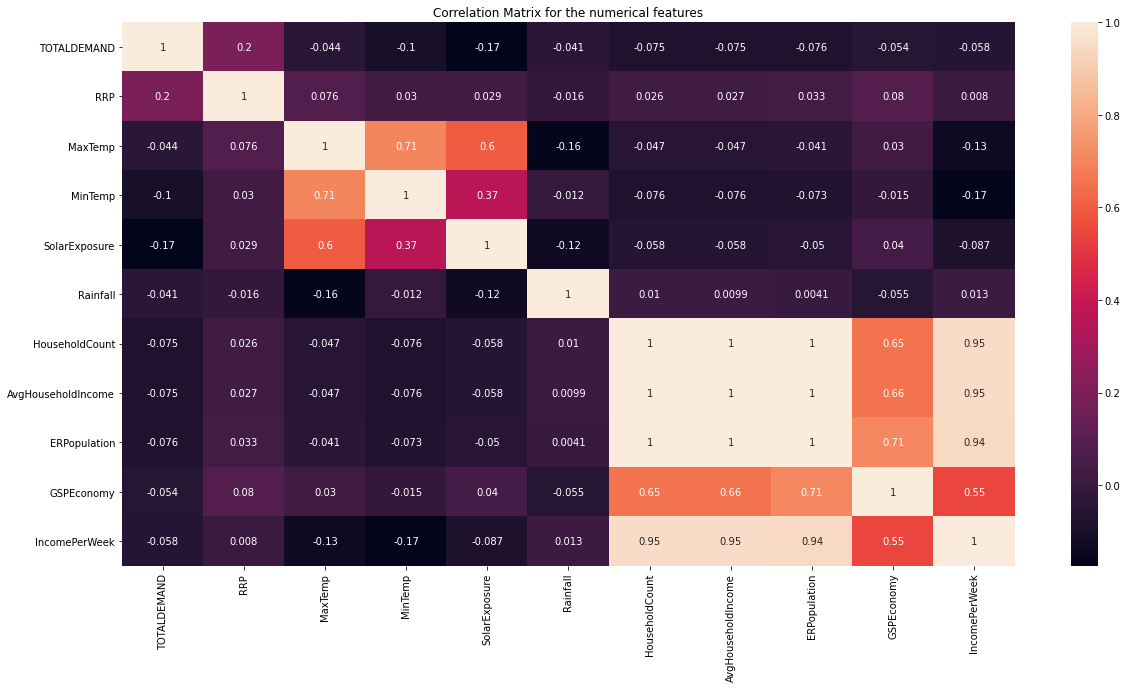

In [21]:
# Plot a correlation matrix between the numerical columns
plt.figure(figsize = (20, 10))
ax = sns.heatmap(df.corr(), annot = True).set_title('Correlation Matrix for the numerical features')
plt.show()

In [22]:
# Uncomment to export the final dataframe as csv
# df.to_csv('data/final_data.csv', index=False)

# 3. Feature Engineering <a class="anchor" id="3"></a>
## 3.1 One-Hot Encoding <a class="anchor" id="3.1"></a>

In [23]:
# Create a one-hot encoded dataframe
dummies = pd.get_dummies(df)

## 3.2 Preparing training and testing data <a class="anchor" id="3.2"></a>

#### Training Data: Data before Covid-19 lockdown

In [24]:
# Select the pre Covid data for the label column
df_train = df[df.SETTLEMENTDATE < '2020-03-16']
# Convert it into an array and reshape as required
y_train = df_train['RRP'].values
y_train = y_train.reshape(-1, 1)

# Select the remaining pre Covid data
X_train = dummies[dummies.SETTLEMENTDATE < '2020-03-16']
# Drop the unnecessary columns
X_train = X_train.drop(['SETTLEMENTDATE', 'AvgHouseholdIncome', 'ERPopulation'], axis = 1)
# Convert it into an array
X_train = X_train.values

#### Testing Data: Data after Covid-19 lockdown

In [25]:
# Select the post Covid data for the label column
df_test = df[df.SETTLEMENTDATE > '2020-03-15']
# Convert it into an array and reshape as required
y_test = df_test['RRP'].values
y_test = y_test.reshape(-1, 1)
y_true = y_test
y_true = y_true.reshape(-1,)

# Select the remaining post Covid data
X_test = dummies[dummies.SETTLEMENTDATE > '2020-03-15']
# Drop the unnecessary columns
X_test = X_test.drop(['SETTLEMENTDATE', 'AvgHouseholdIncome', 'ERPopulation'], axis = 1)
# Convert it into an array
X_test = X_test.values

## 3.3 Scaling the data <a class="anchor" id="3.3"></a>

#### Training Data: Data before Covid-19 lockdown

In [26]:
# Scale down the data using Standard Scalar for the label column of training data
y_train_scaler = StandardScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)
y_train = y_train.reshape(-1,)

# Scale down the data using Standard Scalar for the rest of the training data
X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)

#### Testing Data: Data after Covid-19 lockdown

In [27]:
# Scale down the data using Standard Scalar for the label column of testing data
y_test_scaler = StandardScaler().fit(y_test)
y_test = y_test_scaler.transform(y_test)
y_test = y_test.reshape(-1,)

# Scale down the data using Standard Scalar for the rest of the testing data
X_test_scaler = StandardScaler().fit(X_test)
X_test = X_test_scaler.transform(X_test)

#### Shape of the data

In [28]:
# Print out the shape of the ready-to-train data
print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train:', y_train.shape)
print('y_test: ', y_test.shape)

X_train: (73727, 183)
X_test:  (10367, 183)
y_train: (73727,)
y_test:  (10367,)


# 4. Multi-layer Perceptron - Artificial Neural Network <a class="anchor" id="4"></a>

## 4.1 Training the MLP-ANN model <a class="anchor" id="4.1"></a>

In [29]:
# Train the MLP-ANN model with 6 layers and 20 neurons in each layer
# Set up the further hyperparameters as:
    # Rectified Linear Unit as the activation function
    # 5000 epochs to train the model

reg = MLPRegressor(hidden_layer_sizes = (20, 20, 20, 20, 20, 20),
                   activation = 'relu',
                   random_state = 1,
                   max_iter = 5000).fit(X_train, y_train)

## 4.2 Getting the predictions <a class="anchor" id="4.2"></a>

In [30]:
# Get and store the predictions from the model
y_pred = reg.predict(X_test)

## 4.3 Testing the MLP-ANN model <a class="anchor" id="4.3"></a>

In [31]:
# Print out the R2 score and the mean squared error for the test
print('Metric scores for predictions:')
print('R2 Score:', round(r2_score(y_test, y_pred), 6))
mse = mean_squared_error(y_test, y_pred)
print('MSE:     ', round(np.sqrt(mse), 6))

Metric scores for predictions:
R2 Score: 0.955882
MSE:      0.210042


In [32]:
# Descale the predicted data to original RRP values
y_pred_inverse = y_test_scaler.inverse_transform(y_pred)

# Print out the R2 score and the mean squared error for the test
print('Metric scores for predictions after descaling the data:')
print('R2 Score:', round(r2_score(y_true, y_pred_inverse), 6))
mse = mean_squared_error(y_true, y_pred_inverse)
print('MSE:     ', round(np.sqrt(mse), 6))

Metric scores for predictions after descaling the data:
R2 Score: 0.955882
MSE:      9.319514


## 4.4 Plotting the labels and predictions for comparison <a class="anchor" id="4.4"></a>

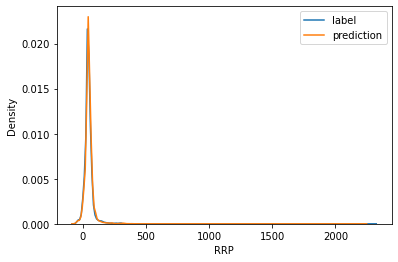

In [33]:
# Visualise the Kernel Density plot for the labels and predictions
ax = sns.kdeplot(y_true, label = 'label')
ax = sns.kdeplot(y_pred_inverse, label = 'prediction').set(xlabel = 'RRP')
plt.legend()
plt.show()

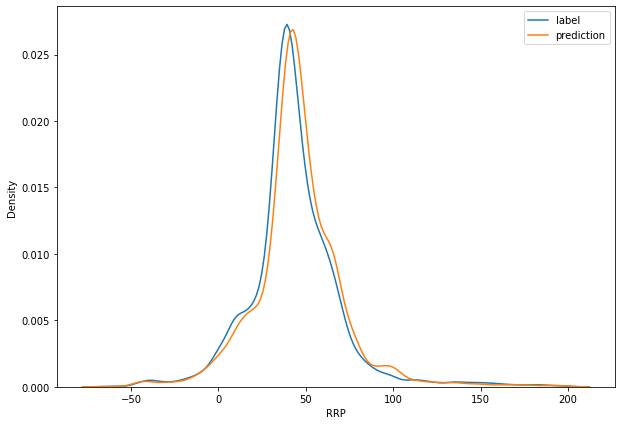

In [34]:
# Considering the high range of values towards the right without any trend
# Limit the values upto a threshold of 200 RRP
label = [x for x in y_true if x <= 200]
pred = [x for x in y_pred_inverse if x <= 200]

# Visualise the Kernel Density plot for the labels and predictions
plt.figure(figsize = (10, 7))
ax = sns.kdeplot(label, label = 'label')
ax = sns.kdeplot(pred, label = 'prediction').set(xlabel = 'RRP')
plt.legend()
plt.show()